In [1]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models import Word2Vec, KeyedVectors
import tensorflow as tf
from keras.models import Sequential, load_model
from keras import layers
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, Lambda, Flatten
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from sklearn.manifold import TSNE
import keras
from keras import backend as K

In [2]:
data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\full_set.csv')
print(data.shape)
data.head(10)

(108201, 6)


,Unnamed: 0,Speaker,Utterances,Basic,General,Full
0,0,fe016,so um,F,fh,fh
1,1,fe016,i was going to try to get out of here like in ...,S,s,rt
2,2,fe016,um,F,fh,fh
3,3,fe016,because i really appreciate people coming.,S,s,s
4,4,fe016,and the main thing that i was going to ask peo...,S,s,s
5,5,fe016,so anything that transcribers or discourse cod...,S,s,e
6,6,fe016,so we have this um,D,fh,fh
7,7,fe016,i think a starting point is clearly the the ch...,S,s,s
8,8,fe016,which don brought a copy of.,S,s,e
9,9,me011,yeah.,B,b,b


In [3]:
data=data.drop(columns=["Unnamed: 0"])
data.head()

,Speaker,Utterances,Basic,General,Full
0,fe016,so um,F,fh,fh
1,fe016,i was going to try to get out of here like in ...,S,s,rt
2,fe016,um,F,fh,fh
3,fe016,because i really appreciate people coming.,S,s,s
4,fe016,and the main thing that i was going to ask peo...,S,s,s


In [4]:
data['Utterances'] = data['Utterances'].apply(lambda x: x.lower())
data['Utterances'] = data['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))
data['Utterances'].head()

0                                                so um
1    i was going to try to get out of here like in ...
2                                                   um
3            because i really appreciate people coming
4    and the main thing that i was going to ask peo...
Name: Utterances, dtype: object

In [5]:
#Creating table of number of each data label present in the dataset
label_count=data.groupby('Basic')['Basic'].agg('count')
label_count.to_numpy(dtype=int)
label_count = np.expand_dims(label_count, axis=0)
label_count.shape=(5,1)
labels=np.array(['B', 'D', 'F', 'Q', 'S'])
labels.shape=(5,1)
label_count=np.column_stack((labels,label_count))

df = pd.DataFrame(label_count, columns=['Label', 'Count'])

convert_dict = {'Label': str,
                'Count': int
               }
  
df = df.astype(convert_dict)
df

,Label,Count
0,B,14620
1,D,14548
2,F,7817
3,Q,6983
4,S,64233


<AxesSubplot:xlabel='Label'>

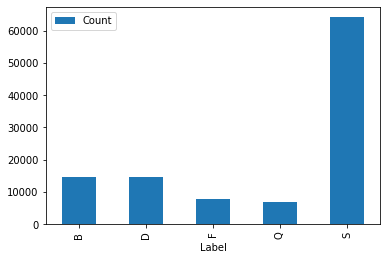

In [6]:
df.plot.bar(x = 'Label', y='Count')

In [7]:
#Tokenizing the words and padding the sentence
MAX_PADDING = 77
tokenizer = Tokenizer(num_words = 5000, split=" ")
tokenizer.fit_on_texts(data['Utterances'].values)
x_train = tokenizer.texts_to_sequences(data['Utterances'].values)
x_train = pad_sequences(x_train, padding='post', maxlen=MAX_PADDING)
print(x_train.shape)
x_train[:2]

(108201, 77)


array([[ 11,  16,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,  36,  59,   4, 168,   4,  61,  81,  10,  97,  35,  15, 438,
         86, 659,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [8]:

y_train = pd.get_dummies(data['Basic']).values
[print(data['Basic'][i],y_train[i]) for i in range (0,5)]

F [0 0 1 0 0]
S [0 0 0 0 1]
F [0 0 1 0 0]
S [0 0 0 0 1]
S [0 0 0 0 1]


[None, None, None, None, None]

In [9]:

f = open("C:\\Users\\user1\\Downloads\\glove.6B\\glove.6B.300d.txt",  encoding="utf8")
embedd_index = {}
for line in f:
    val = line.split()
    word = val[0]
    coff = np.asarray(val[1:],dtype = 'float')
    embedd_index[word] = coff

f.close()
print('Found %s word vectors.' % len(embedd_index))

Found 400000 word vectors.


In [10]:
embedd_index['good']

array([-1.3602e-01, -1.1594e-01, -1.7078e-02, -2.9256e-01,  1.6149e-02,
        8.6472e-02,  1.5759e-03,  3.4395e-01,  2.1661e-01, -2.1366e+00,
        3.5278e-01, -2.3909e-01, -2.2174e-01,  3.6413e-01, -4.5021e-01,
        1.2104e-01, -1.5596e-01, -3.8906e-02, -2.9419e-03,  1.6009e-02,
       -1.1620e-01,  3.8680e-01,  3.5109e-01,  9.7426e-02, -1.2425e-02,
       -1.7864e-01, -2.3259e-01, -2.6960e-01,  4.1083e-02, -7.6194e-02,
       -2.3362e-01,  2.0919e-01, -2.7264e-01,  5.4967e-02, -1.8055e+00,
        5.6348e-01, -1.2778e-01,  2.3147e-01, -5.8820e-03, -2.6630e-01,
        4.1187e-01, -3.7162e-01, -2.0600e-01, -1.9619e-01, -4.3945e-03,
        1.2513e-01,  4.6638e-01,  4.5159e-01, -1.5000e-01,  5.9589e-03,
        5.9070e-02, -4.1440e-01,  6.1035e-02, -2.1117e-01, -4.0988e-01,
        5.6393e-01,  2.3021e-01,  2.7240e-01,  4.9364e-02,  1.4239e-01,
        4.1841e-01, -1.3983e-01,  3.4826e-01, -1.0745e-01, -2.5002e-01,
       -3.2554e-01,  3.3343e-01, -3.5617e-01,  2.0442e-01,  1.44

In [11]:
index_of_words = tokenizer.word_index
print(len(index_of_words))

11113


In [12]:
embedding_matrix = np.zeros((len(index_of_words) + 1, 300))

tokens = []
labels = []

for word,i in index_of_words.items():
    temp = embedd_index.get(word)
    if temp is not None:
        embedding_matrix[i] = temp
        
embedding_matrix.shape

(11114, 300)

In [13]:
embedd_layer = Embedding(input_dim=len(index_of_words) + 1 , 
                         output_dim=300 , 
                         input_length = 77 , 
                         weights = [embedding_matrix])

In [14]:
MAX_LENGTH_PER_SENTENCE=77
units = 128
encoder_input = keras.Input(shape=(MAX_LENGTH_PER_SENTENCE))
x = layers.Embedding(input_dim=len(index_of_words) + 1 , 
                     output_dim=300 , 
                     input_length = 77 , 
                     weights = [embedding_matrix])(encoder_input)
                              
activations = layers.Bidirectional(layers.LSTM(units, 
                                               dropout=0.3, 
                                               recurrent_dropout=0.2,
                                               return_sequences=True))(x)

attention = layers.Dense(1, activation='tanh')(activations)
attention = layers.Flatten()(attention)
attention = layers.Activation('softmax')(attention)
attention = layers.RepeatVector(units*2)(attention)
attention = layers.Permute((2, 1))(attention)

sent_representation = layers.Multiply()([activations, attention])
sent_representation = layers.Lambda(lambda X: K.sum(X, axis=-2), output_shape=(units*2,))(sent_representation)


probabilities = layers.Dense(5, activation='softmax')(sent_representation)


encoder = keras.Model(inputs=[encoder_input], outputs=[probabilities],name='encoder')

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 77)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 77, 300)      3334200     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 77, 256)      439296      embedding_1[0][0]                
__________________________________________________________________________________________________
dense (Dense)                   (None, 77, 1)        257         bidirectional[0][0]              
____________________________________________________________________________________________

In [15]:
encoder.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
#Early stopping the training when accuracy decreases
es = keras.callbacks.EarlyStopping(monitor='accuracy', mode='auto', patience=1, verbose=1)

In [17]:
encoder.fit(x_train, y_train, epochs=1000, batch_size=32, callbacks=[es], verbose=1)

Epoch 1/1000
3382/3382 [==============================] - 1276s 376ms/step - loss: 0.6386 - accuracy: 0.7636
Epoch 2/1000
3382/3382 [==============================] - 1258s 372ms/step - loss: 0.5388 - accuracy: 0.7999
Epoch 3/1000
3382/3382 [==============================] - 1234s 365ms/step - loss: 0.5066 - accuracy: 0.8109
Epoch 4/1000
3382/3382 [==============================] - 1228s 363ms/step - loss: 0.4836 - accuracy: 0.8173
Epoch 5/1000
3382/3382 [==============================] - 1243s 368ms/step - loss: 0.4644 - accuracy: 0.8244
Epoch 6/1000
3382/3382 [==============================] - 1232s 364ms/step - loss: 0.4479 - accuracy: 0.8293
Epoch 7/1000
3382/3382 [==============================] - 1234s 365ms/step - loss: 0.4327 - accuracy: 0.8352
Epoch 8/1000
3382/3382 [==============================] - 1233s 364ms/step - loss: 0.4185 - accuracy: 0.8397
Epoch 9/1000
3382/3382 [==============================] - 1237s 366ms/step - loss: 0.4080 - accuracy: 0.8435
Epoch 10/1000
3382/

In [18]:
#Test set processing
test_set = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\test.csv')
test_set = test_set.drop(columns=["Unnamed: 0"])
test_set['Utterances'] = test_set['Utterances'].apply(lambda x: x.lower())
test_set['Utterances'] = test_set['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

tokenizer = Tokenizer(num_words = 5000, split=" ")
tokenizer.fit_on_texts(test_set['Utterances'].values)
x_test = tokenizer.texts_to_sequences(test_set['Utterances'].values)
x_test = pad_sequences(x_test, padding='post', maxlen=MAX_PADDING)

y_test = pd.get_dummies(test_set['Basic']).values
[print(test_set['Basic'][i],y_test[i]) for i in range (0,5)]

S [0 0 0 0 1]
S [0 0 0 0 1]
S [0 0 0 0 1]
F [0 0 1 0 0]
S [0 0 0 0 1]


[None, None, None, None, None]

In [19]:
score = encoder.evaluate(x_test, y_test)

522/522 [==============================] - 32s 61ms/step - loss: 2.7688 - accuracy: 0.5094


In [20]:
#Saving the model
encoder.save('savedModel.h5')

C:\Users\user1\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [22]:
#Loading the saved model
model1 = load_model('savedModel.h5')
y_pred = model1.predict(x_test)
print(y_pred[1])

[1.3715821e-05 7.6933110e-01 1.0784482e-04 2.1645471e-02 2.0890191e-01]


In [23]:
x_test[1]=np.array(x_test[1])
x_test[1].reshape(1, 77)

array([[52, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [24]:
y_pred = np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

C:\Users\user1\AppData\Local\Programs\Python\Python39\lib\site-packages\pycm\pycm_obj.py:951: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(title)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

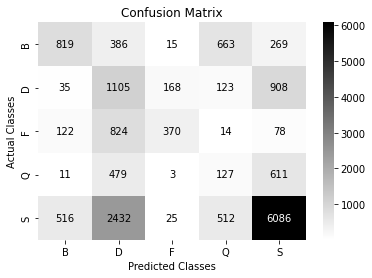

In [25]:
from pycm import *
cm = ConfusionMatrix(y_test, y_pred,digit=5)
cm.relabel(mapping={0:"B",1:"D",2:"F",3:"Q",4:"S"})
cm.plot(plot_lib = "seaborn",number_label=True)

C:\Users\user1\AppData\Local\Programs\Python\Python39\lib\site-packages\pycm\pycm_obj.py:951: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title(title)


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

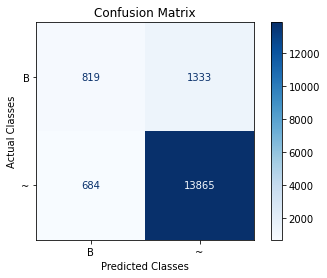

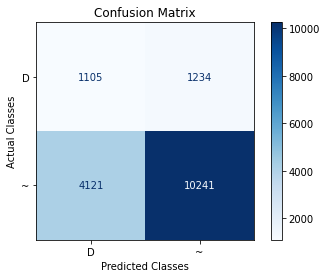

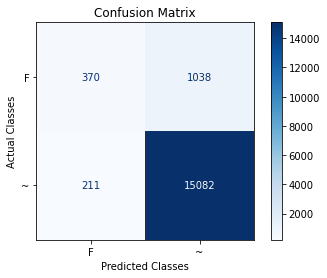

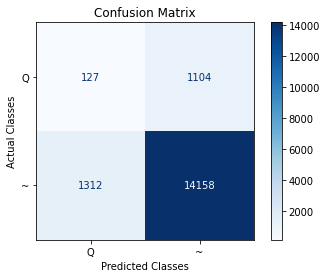

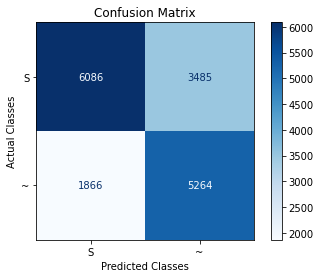

In [26]:
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="B")
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="D")
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="F")
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="Q")
cm.plot(cmap=plt.cm.Blues, number_label=True, one_vs_all=True, class_name="S")

In [27]:
DA = np.array(['B','D','F','Q','S'])
a = ["will you go"]
a = tokenizer.texts_to_sequences(a)
a = np.array(a)
a = pad_sequences(a, padding='post', maxlen=MAX_PADDING)
prediction = model1.predict(np.array(a))
DA[prediction.argmax(1)]

array(['D'], dtype='<U1')